## Exporting a SSD model to CoreML
To use a Fireball model in an iOS application, we can use ```exportToCoreMl``` method. This notebook shows how to use this function to create a CoreML model ready to be deployed in an iOS app. It assumes a trained SSD model already exists in the ```Models``` directory. Please refer to the notebook [Object Detection with SSD](SSD.ipynb) for more info about using a pretrained SSD model.

Fireball can also export models with reduced number of parameters, pruned models, and quatized models. Please refer to the following notebooks for more information:

- [Reducing number of parameters of SSD Model](SSD-Reduce.ipynb)
- [Pruning SSD Model](SSD-Prune.ipynb)
- [Quantizing SSD Model](SSD-Quantize.ipynb)


Note: Fireball uses the ```coremltools``` python package to export CoreML models. If this is not installed you can just run the following command in a new cell and restart the kernel.
```
%pip install coremltools==3.4
```

## Load a pretrained model

In [1]:
from fireball import Model

# orgFileName = "Models/SSD512.fbm"        # Original model
# orgFileName = "Models/SSD512QR.fbm"      # Quantized - Retrained
# orgFileName = "Models/SSD512PR.fbm"      # Pruned - Retrained
# orgFileName = "Models/SSD512PRQR.fbm"    # Pruned - Retrained - Quantized - Retrained
# orgFileName = "Models/SSD512RR.fbm"      # Reduced - Retrained
# orgFileName = "Models/SSD512RRQR.fbm"    # Reduced - Retrained - Quantized - Retrained
# orgFileName = "Models/SSD512RRPR.fbm"    # Reduced - Retrained - Pruned - Retrained
orgFileName = "Models/SSD512RRPRQR.fbm"  # Reduced - Retrained - Pruned - Retrained - Quantized - Retrained


model = Model.makeFromFile(orgFileName, gpus='0')   
model.initSession()
model.printLayersInfo()


Reading from "Models/SSD512RRPRQR.fbm" ... Done.
Creating the fireball model "SSD512" ... Done.

Scope            InShape       Comments                 OutShape      Activ.   Post Act.        # of Params
---------------  ------------  -----------------------  ------------  -------  ---------------  -----------
IN_IMG                         Image Size: 512x512x3    512 512 3     None                      0          
S1_L1_CONV       512 512 3     KSP: 3 1 s               512 512 64    ReLU                      1,680      
S1_L2_CONV       512 512 64    KSP: 3 1 s               256 256 64    ReLU     MP(KSP):2 2 s    28,323     
S2_L1_CONV       256 256 64    KSP: 3 1 s               256 256 128   ReLU                      52,799     
S2_L2_CONV       256 256 128   KSP: 3 1 s               128 128 128   ReLU     MP(KSP):2 2 s    100,941    
S3_L1_CONV       128 128 128   KSP: 3 1 s, LR136        128 128 256   ReLU                      145,999    
S3_L2_CONV       128 128 256   KSP: 3 

## Exporting to CoreML
CoreML handles the pre-processing of the images inside the model. The arguments ```rgbBias``` and ```scale``` are used to tell CoreML how to do this pre-processing. The pre-processed image is calculated by CoreML as:

```
processedImage = image * scale + rgbBias
```

For SSD, the processed images must be in BGR format with values normalized using the mean values 103.939, 116.779, 123.68 for blue, green, and red respectively. So, we are using the following values:
```
scale=1        # This is the default
rgbBias=[-123.68, -116.779, -103.939]
isBgr=True
```

In [2]:
from fireball.datasets.coco import CocoDSet
import os

# We don't need any datasets here. We are just doing this to initialize the CocoDSet
# so that we can get classNames which is needed for the "exportToCoreMl" function below.
CocoDSet.makeDatasets('Test', batchSize=128, resolution=512, keepAr=False, numWorkers=4)

cmlFileName = orgFileName.replace('.fbm', '.mlmodel')

model.exportToCoreMl(cmlFileName, labels=CocoDSet.classNames[1:], # Do not include class 0 (Background)
                     isBgr=True, rgbBias=[-123.68, -116.779, -103.939])

orgFileSize = os.stat("Models/SSD512.fbm").st_size
print('Original Model File Size: {:,} bytes'.format(orgFileSize))
fileSize = os.stat(cmlFileName).st_size
print('CoreML Model File Size: {:,} bytes ({:2.2%} of original)'.format(fileSize, fileSize/orgFileSize))



Exporting to CoreML model "Models/SSD512RRPRQR.mlmodel" ... 
    Exported all 28 layers.                               
    Saving to "Models/SSD512RRPRQR.mlmodel" ... Done.
Done (346.43 Sec.)
Original Model File Size: 142,582,863 bytes
CoreML Model File Size: 17,046,469 bytes (11.96% of original)


## Using netron to visualize the exported model
We can now visualize the model's network structure using the "netron" package. If netron is not installed, you can just run the following command in a new cell and restart the kernel.

```
%pip install netron
```

In [3]:
import netron
import platform

if platform.system() == 'Darwin':      # Running on MAC
    netron.start(cmlFileName)   
else:
    import socket
    hostIp = socket.gethostbyname(socket.gethostname())
    netron.start(cmlFileName, address=(hostIp,8084))

Serving 'Models/SSD512RRPRQR.mlmodel' at http://10.21.16.50:8084


## Running inference on the exported model
To verify the exported model, we can now run inference on it. Currently the CoreML runtime is only available on Mac. You also need the pillow package because CoreML only accepts images in this format. If pillow is not installed, you can just run the following command in a new cell and restart the kernel.

```
%pip install pillow
```

Number of detected objects: 15
    0: broccoli (99%) at [0.77501128 0.72385929 0.21538238 0.21538238]
    1: apple (98%) at [0.51559727 0.56831543 0.27094427 0.27094427]
    2: sandwich (98%) at [0.35964873 0.23821189 0.20771636 0.20771636]
    3: broccoli (98%) at [0.23661953 0.11214913 0.19105166 0.19105166]
    4: broccoli (98%) at [0.79717064 0.48110104 0.20491505 0.20491505]
    5: broccoli (97%) at [0.7456212  0.25674778 0.1962955  0.1962955 ]
    6: apple (97%) at [0.49986085 0.23725414 0.29845649 0.89536941]
    7: sandwich (94%) at [0.06033423 0.22451956 0.21339338 0.21339338]
    8: broccoli (93%) at [0.63982729 0.05201418 0.16634409 0.16634409]
    9: broccoli (91%) at [0.5578763  0.20591469 0.20497236 0.20497236]
    10: broccoli (90%) at [0.46924076 0.0758364  0.17821448 0.17821448]
    11: sandwich (85%) at [0.18851159 0.37015701 0.17491476 0.17491476]
    12: sandwich (83%) at [0.16430068 0.57557555 0.18033016 0.36066028]
    13: sandwich (81%) at [0.02785993 0.50137877 

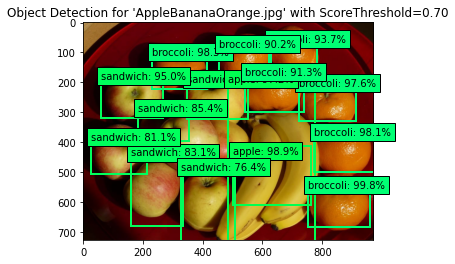

In [4]:
assert platform.system() == 'Darwin', "This is only supported when running on Mac!"

import PIL
import numpy as np
import matplotlib.pyplot as plt

classNames = CocoDSet.classNames[1:]

# First load and pre-process the image:
imgFileName = 'AppleBananaOrange.jpg'
pilImage = PIL.Image.open(imgFileName)
imgW, imgH = pilImage.size

img = np.array(pilImage)
pilImage = pilImage.resize((512, 512), PIL.Image.BILINEAR)

# Load the CoreML model and run inference on it
import coremltools
scoreThreshold = .7
iouThreshold = .35
model = coremltools.models.MLModel(cmlFileName)
results = model.predict({'InputImage': pilImage, 
                         'iouThreshold':iouThreshold, 
                         'confidenceThreshold':scoreThreshold}, useCPUOnly=True)

scores = results['scores']
boxes = results['boxes']   # Boxes are in the form centerX,centerY,W,H
classes = np.int32( [np.argmax( score ) for score in scores ])

# The boxes returned by the CoreML model are: centerX, centerY, width, height
# The following line converts all boxes to: left, top, width, height
boxes[:,:2] -= boxes[:,2:]/2.0

currentAxis = plt.gca()
colors = plt.cm.hsv(np.linspace(0, 1, 121)).tolist()

dtNum = len(classes)
print("Number of detected objects: %d"%(dtNum))
for i in range(int(dtNum)):
    dtClass, dtBox, dtScore = int(classes[i]), boxes[i], scores[i][classes[i]]
    print("    %d: %s (%d%%) at %s"%(i, classNames[dtClass],int(dtScore*100),str(dtBox)))

    caption = "%s: %2.1f%%"%(classNames[ dtClass ], dtScore*100)
    dtBox *= [imgW,imgH,imgW,imgH]
    x,y, w,h = np.int32( np.rint(dtBox) )
    
    currentAxis.add_patch(plt.Rectangle((x,y), w,h, fill=False, edgecolor=colors[ dtClass ], linewidth=2))
    currentAxis.text(x,y, caption, bbox={'facecolor':colors[ dtClass ]}, verticalalignment='top')

imgplot = plt.imshow(img)
plt.title("Object Detection for '%s' with ScoreThreshold=%.2f"%(imgFileName, scoreThreshold))
plt.show()


## Where do I go from here?

[Exporting SSD Model to ONNX](SSD-ONNX.ipynb)

[Exporting SSD Model to TensorFlow](SSD-TF.ipynb)

---

[Fireball Playgrounds](../Contents.ipynb)

[Object Detection with SSD](SSD.ipynb)

[Reducing number of parameters of SSD Model](SSD-Reduce.ipynb)

[Pruning the SSD Model](SSD-Prune.ipynb)

[Quantizing SSD Model](SSD-Quantize.ipynb)
